In [ ]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, \
      Add, Concatenate, Bidirectional, SimpleRNN, LSTM, GRU, \
      LayerNormalization, Conv1D, MaxPooling1D, Lambda, GlobalAveragePooling1D

!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation

# if running from google drive
from google.colab import drive
drive.mount('/content/drive')

# cd to correct directory (the one containing this notebook)
%cd /content/drive/My\ Drive/4-2/COMP4332/Project1
!pwd # check working directory is correct


stop_words = set(stopwords.words("english"))
stop_words.remove("not") # added by HCJ
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/4-2/COMP4332/Project1
/content/drive/My Drive/4-2/COMP4332/Project1


## Data Loader

In [ ]:
def load_data(file_name, no_stars=False):
    df = pd.read_csv(file_name)
    if no_stars:
        dummy = None
    else:
        dummy = df["stars"]
    return df["review_id"], df["text"], dummy

def write_predictions(file_name, pred, text):
    d = {'review_id': text, 'stars': pred}
    df = pd.DataFrame(d)
    df.to_csv(file_name, index=False)

## Feature Extractor

- Token, Stemming, Stopwords, Punctuation

In [ ]:
def tokenize(text):
    return nltk.word_tokenize(text)

def stem(tokens):
    return [ps.stem(token).lower() for token in tokens]

def filter_stopwords(tokens):
    return [token for token in tokens if token not in stop_words and not token.isnumeric()]

def remove_punc(tokens):
    return ''.join([token.lower() for token in tokens if token not in punctuation])

def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    global unk_count
    """
    :param feats: a list of features within a given data point/review, type: list
    :param feats_dict: a dict from features (tokens) to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature does not exist
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

In [ ]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
actual_test_file = "data/test.csv"

# load data
train_ids, train_texts, train_labels = load_data(train_file)
valid_ids, valid_texts, valid_labels = load_data(valid_file)
test_ids_ac, test_texts_ac, _ = load_data(actual_test_file, no_stars=True)
print(valid_texts)

0       We came in today during closing & they still a...
1       Tiny, but casual location for breakfast/brunch...
2       We keep going to the same plaza to eat pizza b...
3       Tim Hortons is the epitome of Canadian mediocr...
4       Workers here are very friendly and they know a...
                              ...                        
1995    I really don't want to give this place 3 stars...
1996    I don't think I'll ever be as satisfied and ha...
1997    The food is delicious and inexpensive. The mus...
1998    Amazing pizza, large variety of food, and a mo...
1999    I honestly had NO IDEA pastries could taste so...
Name: text, Length: 2000, dtype: object


## Classifier: RNN

In [ ]:

# returns sorted indices of unique values, then the occurrence of each of those values
tr_unique_vals, tr_unique_counts = np.unique(train_labels, return_counts=True)
LDAM_n_j = tf.math.sqrt(tf.math.sqrt(tf.convert_to_tensor(tr_unique_counts, np.float32))) # derived, HCJ
LDAM_C = tf.constant(-1, dtype="float32") # hyperparamter, can tune, HCJ
print(LDAM_n_j)
print(LDAM_C)

#print(tr_unique_counts)
#print(LDAM_n_j)

def LDAM(targets, preds):
  global LDAM_C
  global LDAM_n_j

  # Let k be the number of unique classes.
  # 'preds' is the set of outputs generated by the model (size B*k) tf Tensor
  # 'targets' is the set of corresponding GT one-hot labels (size B*k) tf Tensor
  # 'LDAM_C' is a hyperparameter to be tuned during validation, 'LDAM_n_j' is a k*1 tf tensor whose ith entry stores (the number of elements who has label i)^(1/4)
  
  deltas = LDAM_C/LDAM_n_j # actually = C/((n_j)^0.25). Is tf tensor of size [k]
  #print(deltas)

  # for a given input x with corresponding label y (y in {0,...,4}) the model predicts a k-dimensional vector (p_0,...,p_{k-1}) where p_i denotes the probability the model believes x belongs to class i
  # we need to extract the necessary values into a tf tensor of size [B] called z_y. Example:
  # (0.40, 0.32, 0.24, 0.02, 0.02) | 0
  # (0.80, 0.04, 0.05, 0.01, 0.10) | 2
  # (0.20, 0.60, 0.10, 0.09, 0.01) | 1
  # ...
  # then we need to extract index 0 from 1st vector, index 2 from 2nd element, index 1 from 3rd vector, etc...: this gives (0.32, 0.05, 0.6, ...)
  # source (tested): https://stackoverflow.com/questions/61096522/pytorch-tensor-advanced-indexing
  # this essentially refers to the probability that the model classified the input x correctly, for all x in the batch
  actual_label = tf.math.argmax(targets, axis=1)
  #print(actual_label)

  z_y = tf.gather(params=preds, indices=actual_label, batch_dims=1)
  #print(z_y)

  deltas_indexed = tf.gather(params=deltas, indices=actual_label, batch_dims=0)
  e_zyminusdeltay = tf.math.exp(z_y - deltas_indexed) # torch tensor of size [B]
  #print(e_zyminusdeltay)

  # since each value of label is in {0,...,4}, doing (actual_label+1) mod k allows us to extract every probability not equal to the probability x was predicted to be y (its corresponding label)
  e_zj_sum = tf.zeros(shape=(targets.shape[0],))
  for i in range(1,5):
      z_j_i = tf.gather(params=preds, indices=(actual_label+i)%5, batch_dims=1)
      #print(tf.math.exp(z_j_i))
      e_zj_sum += tf.math.exp(z_j_i)
  
  #print(e_zj_sum)
  # compute L_LDAM((x,y);f) for all x in the batch. Use nat log
  result = -tf.math.log(e_zyminusdeltay/(e_zyminusdeltay+e_zj_sum))
  #print(result)

  # take average of the entries to get a real-valued result
  return tf.math.reduce_mean(result)

TEST1 = tf.convert_to_tensor(np.array([[0.40, 0.32, 0.24, 0.02, 0.02],
                 [0.80, 0.04, 0.05, 0.01, 0.10],
                 [0.20, 0.60, 0.10, 0.09, 0.01]]), np.float32)
TEST2 = tf.convert_to_tensor(np.array([[1, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0],
                 [0, 1, 0, 0, 0]]), np.float32)
ldam_test = LDAM(TEST2, TEST1)
print(ldam_test)


def macro_soft_f1(y, y_hat):
    """If we want to optimize macro-F1 score, we can use it as a loss function.
    However since it not differentiable, we use soft F1 as loss instead.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (B, k) where B = batch size, k = number of classes
        y_hat (float32 Tensor): probability matrix of shape (B, k)
        
    Returns:
        cost (scalar Tensor): value of the loss function for the batch
    """
    
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

tf.Tensor([7.1896725 6.1782417 6.678189  7.9382534 9.431003 ], shape=(5,), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(1.3755213, shape=(), dtype=float32)


In [ ]:
def attention_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,                        
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              trainable=False,
              metric='accuracy'):
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer

    # The model will take as input an integer matrix of size (batch, input_length),
    # and the largest integer (i.e. word index) in the input should be no larger than vocab_size-1
    # Now output shape is (batch, input_length, output_dim)
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=trainable, mask_zero=True)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)

    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    #h = SeqSelfAttention(attention_activation='sigmoid')(h)
    if bidirectional:
        h = Bidirectional(fn(hidden_size,
                                    kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                    recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                    return_sequences=True,recurrent_dropout=dropout_rate))(h)
    else:
        h = fn(hidden_size,
                                    kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                    recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                    return_sequences=True,recurrent_dropout=dropout_rate)(h)
    #h = Dropout(dropout_rate, seed=0)(h)
    h = SeqWeightedAttention()(h)
    #h = SeqSelfAttention(attention_activation='sigmoid')(h)
    #h = GlobalAveragePooling1D()(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),    ## He initializer
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        new_h = Activation(activation)(new_h) # add activation
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else: 
            h = Add()([h, new_h])
    
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),      ## He initializer
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)

    if loss=="LDAM": # added by HCJ
        model.compile(loss=LDAM, optimizer=optimizer, metrics=[metric])
    elif loss=="macro_soft_f1": # added by HCJ
        model.compile(loss=macro_soft_f1, optimizer=optimizer, metrics=[metric])
    else:
        model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [ ]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,                        
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              trainable=False,
              metric='accuracy'):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: list of str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer

    # The model will take as input an integer matrix of size (batch, input_length),
    # and the largest integer (i.e. word index) in the input should be no larger than vocab_size-1
    # Now output shape is (batch, input_length, output_dim)
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=trainable)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    # BatchNorm and Conv layers added by HCJ
    #emb = Conv1D(filters=200, kernel_size=3)(emb)
    #emb = BatchNormalization()(emb)
    #emb = Activation(activation)(emb)
    #emb = MaxPooling1D(pool_size=2)(emb)

    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    unused = """for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)"""

    for i in range(num_rnn_layers):
        should_return_seq = (i < num_rnn_layers - 1) # last layer shouldn't return sequence
        if bidirectional:
            # hidden_size = number of LSTM units in a layer
            # if input to an LSTM layer is (B, T, F) where B=batch size, T=timesteps, F=features, output of bidirectional LSTM is:
            # (B, hidden_size) if not returning sequence
            # (B, T, hidden_size) if returning sequence
            rnn_h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=should_return_seq))(h)
        else:
            rnn_h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=should_return_seq)(h)
        rnn_h = Dropout(dropout_rate, seed=0)(rnn_h)
        if should_return_seq:
            # set residual connections for stacked LSTM as per:
            # https://stackoverflow.com/questions/60772323/how-to-implement-a-skip-connection-structure-between-lstm-layers
            if i > 0: #or h.shape[-1] == hidden_size:
                h = Add()([h, rnn_h])
            else: 
                # only occurs if:
                # i==0. This basically means we always want to apply LSTM at least once
                h = rnn_h
        else:
            if num_rnn_layers==1:
                h = rnn_h
            else:
                # only occurs at the last layer (since that is the ONLY layer we are not returning a sequence), so
                # select only the last element of the previous output.
                def slice_last(x):
                    return x[..., -1, :]
                h = Add()([Lambda(slice_last)(h), rnn_h])
    # the output of recurrent layer should be h, not rnn_h
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),    ## He initializer
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else: 
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),      ## He initializer
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)

    if loss=="LDAM": # added by HCJ
        model.compile(loss=LDAM, optimizer=optimizer, metrics=[metric])
    elif loss=="macro_soft_f1": # added by HCJ
        model.compile(loss=macro_soft_f1, optimizer=optimizer, metrics=[metric])
    else:
        model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

## Google pretrained embedding

In [ ]:
from gensim import models
%cd /content/drive/My\ Drive/4-2/COMP5214/A2
path = "./GoogleNews-vectors-negative300.bin"
limit=3000000
gensim_model = models.KeyedVectors.load_word2vec_format(path, binary=True, limit=limit) 
%cd /content/drive/My\ Drive/4-2/COMP4332/Project1

/content/drive/My Drive/4-2/COMP5214/A2
/content/drive/My Drive/4-2/COMP4332/Project1


In [ ]:
# TODO use this if augmentation successful
train_texts_aug = train_texts
train_labels_aug = train_labels

In [ ]:
# extract features
train_no_punc = [remove_punc(text) for text in train_texts_aug] # use standard train_texts here if this doesn't work
valid_no_punc = [remove_punc(text) for text in valid_texts]

train_tokens = [tokenize(text) for text in train_no_punc]
valid_tokens = [tokenize(text) for text in valid_no_punc]

train_stop = [filter_stopwords(tokens) for tokens in train_tokens]
valid_stop = [filter_stopwords(tokens) for tokens in valid_tokens]

# removed stemming for Google word embeddings since many of them 'miss'
#train_stemmed = [stem(tokens) for tokens in train_stop]
#valid_stemmed = [stem(tokens) for tokens in valid_stop]

train_features = train_stop
valid_features = valid_stop

test_no_punc_ac = [remove_punc(text) for text in test_texts_ac]
test_tokens_ac = [tokenize(text) for text in test_no_punc_ac]
test_stop_ac = [filter_stopwords(tokens) for tokens in test_tokens_ac]
# removed stemming
#test_stemmed_ac = [stem(tokens) for tokens in test_stop_ac]
test_features_ac = test_stop_ac

In [ ]:
min_freq = 20
max_freq = -1
# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_features),
    min_freq=min_freq,
    max_freq=max_freq)

Size of features: 4894


In [ ]:
print(sorted(feats_dict, key=feats_dict.get, reverse=True)[:1000])

['roy', 'papa', 'randomly', 'sassy', 'wiped', 'trustworthy', 'kalbi', 'washer', 'rail', 'ben', 'niece', 'icecream', 'dancers', 'pregnancy', 'marriott', 'lineup', 'extraordinary', 'changs', 'warmed', 'haircuts', 'instant', 'worthwhile', 'lab', 'category', 'consultation', 'walnuts', 'tricky', 'shark', 'justin', 'hooters', 'mental', 'sorbet', 'buttermilk', 'cactus', 'bloor', 'hunger', 'carb', 'encounter', 'filed', 'rob', 'hoagie', 'calzone', 'cox', 'drugs', 'gates', 'reaction', 'afterward', 'hat', 'brief', 'gut', 'excitement', 'chemicals', 'gems', 'banh', 'skimp', 'jacket', 'brewed', 'kinks', 'spam', 'tours', 'carbs', 'granite', 'rubbery', 'swing', 'crackers', 'johns', 'negatives', 'speaker', 'agency', 'alcoholic', 'yall', 'feeding', 'moneys', 'breeze', 'wherever', 'struggle', 'mama', 'lemongrass', 'jus', 'lite', 'filter', 'presence', 'clock', 'mojito', 'player', 'jalapenos', 'clueless', 'international', 'gal', 'norm', 'repeatedly', 'asleep', 'gallery', 'bubbly', 'pint', 'artificial', 'ro

In [ ]:
max_len = 256 # each review will become an nparray of this length, where each element of said array is a word's integer representation

# build the feature matrix by converting each data point (review) to a index vector, and then stack vectors to form matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_features])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_features])
test_feats_matrix_ac = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_features_ac])

num_classes = max(train_labels)

# convert each label to a one-hot vector, and then stack vectors as a matrix
train_label_matrix = to_categorical(train_labels_aug-1, num_classes=num_classes)
valid_label_matrix = to_categorical(valid_labels-1, num_classes=num_classes)

In [ ]:
EMBEDDING_SIZE = 300
embedding_matrix = np.zeros((len(feats_dict), EMBEDDING_SIZE), dtype=np.float32)
hits = 0
misses = 0

for word in feats_dict:
    word_idx = feats_dict.get(word, -1)
    if word in gensim_model:
        embedding_matrix[word_idx] = np.array(gensim_model[word], dtype=np.float32)
        hits+=1
    else:
        print(word)
        embedding_matrix[word_idx] = np.array(np.zeros(EMBEDDING_SIZE), dtype=np.float32)
        misses+=1

print("Converted %d words (%d misses)" % (hits, misses))
print(embedding_matrix.shape)

<pad>
<unk>
didnt
wasnt
doesnt
isnt
flavour
favourite
shouldnt
flavours
ayce
bellagio
hasnt
neighbourhood
theatre
cancelled
mandalay
blt
phx
glutenfree
cest
summerlin
dennys
brussel
soso
centre
instagram
markham
aint
doughnut
10am
80s
doughnuts
colour
90s
10pm
11am
grey
panera
yonge
11pm
summerlicious
luxor
ihop
applebees
vdara
dente
savoury
innout
michelin
montréal
bloor
changs
marriott
Converted 4840 words (54 misses)
(4894, 300)


In [ ]:
import warnings
warnings.filterwarnings("ignore") # ignore UndefinedMetricWarning that occurs when training (since support of F-score and precision for some classes may be 0)

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        # convert from one-hot back to class labels
        train_predict = np.argmax((np.asarray(self.model.predict(train_feats_matrix))).round(), axis=1)
        train_targ = np.argmax(train_label_matrix, axis=1)

        val_predict = np.argmax((np.asarray(self.model.predict(valid_feats_matrix))).round(), axis=1)
        val_targ = np.argmax(valid_label_matrix, axis=1)

        print("\n")
        print(classification_report(train_targ, train_predict, labels=[0, 1, 2, 3, 4]))
        print(classification_report(val_targ, val_predict, labels=[0, 1, 2, 3, 4]))
        print("\n")
        return
 
metrics = Metrics()

In [ ]:
os.makedirs("models", exist_ok=True)
# create bidirectional LSTM model with stacked LSTM layers to learn higher-level features
# we have BatchNorm, dropout and L2 regularization already within our model so don't need to make dropout parameter p very large else we risk underfitting
unused = """model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=EMBEDDING_SIZE, hidden_size=64, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=1,
                  embedding_matrix=embedding_matrix, trainable=True,
                  activation="relu",
                  loss="macro_soft_f1", # added by HCJ
                  batch_norm=True, learning_rate=2e-5,
                  l2_reg=0.001, dropout_rate=0.2)"""

model = attention_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=EMBEDDING_SIZE, hidden_size=64, output_size=num_classes,
                  rnn_type="lstm", bidirectional=False, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix, trainable=True,
                  activation="relu",
                  loss="LDAM", # added by HCJ
                  batch_norm=True, learning_rate=2e-5,
                  l2_reg=0.0001, dropout_rate=0.2)

best_model_name = "bilstm_weights_attention_final.hdf5" 
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", best_model_name),
    monitor="val_loss", # changed from val_accuracy to val_loss
    verbose=0,
    save_best_only=False)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 256, 300)          1468200   
                                                                 
 lstm_1 (LSTM)               (None, 256, 64)           93440     
                                                                 
 seq_weighted_attention_1 (S  (None, 64)               65        
 eqWeightedAttention)                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                           

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)
cnn_bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(valid_feats_matrix, valid_label_matrix), # added by HCJ
                    epochs=10, batch_size=100, verbose=1, shuffle=True, # added verbose=1, changed epochs
                    callbacks=[checkpointer, earlystopping, metrics]) # added metrics to compute F1 score

Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 1.2346 - accuracy: 0.5894

              precision    recall  f1-score   support

           0       0.28      0.98      0.43      2672
           1       0.00      0.00      0.00      1457
           2       0.00      0.00      0.00      1989
           3       0.64      0.20      0.30      3971
           4       0.84      0.78      0.81      7911

    accuracy                           0.53     18000
   macro avg       0.35      0.39      0.31     18000
weighted avg       0.55      0.53      0.49     18000

              precision    recall  f1-score   support

           0       0.26      0.97      0.41       282
           1       0.00      0.00      0.00       136
           2       0.00      0.00      0.00       212
           3       0.57      0.18      0.27       466
           4       0.81      0.72      0.76       904

    accuracy                           0.50      2000
   macro avg       0.33      0.37 

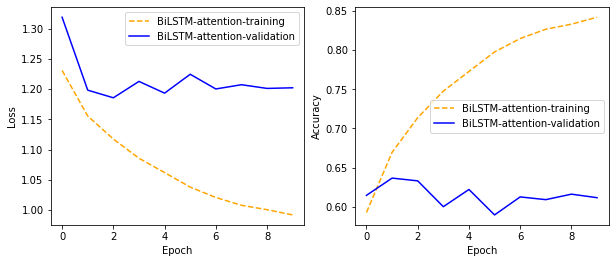

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(cnn_bilstm_history.history["loss"], label="BiLSTM-attention-training", color="orange", linestyle="dashed")
plt.plot(cnn_bilstm_history.history["val_loss"], label="BiLSTM-attention-validation", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_bilstm_history.history["accuracy"], label="BiLSTM-attention-training", color="orange", linestyle="dashed")
plt.plot(cnn_bilstm_history.history["val_accuracy"], label="BiLSTM-attention-validation", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy") # not representative of macro F1 though
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model(os.path.join("models", best_model_name),
                                custom_objects={"macro_soft_f1": macro_soft_f1, 
                                                "SeqWeightedAttention": SeqWeightedAttention,
                                                'LDAM':LDAM})





# actual test set predictions
ts_pred_ac = np.argmax(model.predict(test_feats_matrix_ac),
                    axis=1)

write_predictions('data/lstm_3_test_pred.csv', ts_pred_ac+1, test_ids_ac) # change from 0-4 back to 1-5